To do
1. Merge the 2 x 2 dataframes
2. Find significance and t test
3. Corret for FDR
4. Report the significant proteins

Analyse control vs disease:
1. Analysis 1 (before)
2. Analysis 2 (after)

Fold_change = <strong>Disease/Control</strong>

In [44]:
import pandas as pd
import os
import yaml
import numpy as np
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

In [66]:
# Load configuration
with open('config.yaml', 'r') as file:
    config = yaml.safe_load(file)

# Accessing config values
imputed_dir = config['datasets']['Imputed_dir']

# Construct filepaths
asthma_after_imputed = os.path.join(imputed_dir, 'asthma_after_imputed.csv')
asthma_before_imputed = os.path.join(imputed_dir, 'asthma_before_imputed.csv')
control_after_imputed = os.path.join(imputed_dir, 'control_after_imputed.csv')
control_before_imputed = os.path.join(imputed_dir, 'control_before_imputed.csv')

# Load the dataframes
df_asthma_after = pd.read_csv(asthma_after_imputed)
df_asthma_before = pd.read_csv(asthma_before_imputed)
df_control_after = pd.read_csv(control_after_imputed)
df_control_before = pd.read_csv(control_before_imputed)

# Accessing config values
significance_dir = config['datasets']['Significance_dir']

# Construct output paths
before_significance = os.path.join(significance_dir, 'Before_significance.csv')
after_significance = os.path.join(significance_dir, 'After_significance.csv')

In [46]:
def remake (df):
    df.drop(columns=["Unnamed: 0.1"], inplace=True)
    # Renaming the second column to 'proteins'
    df.rename(columns={"Unnamed: 0": "Proteins"}, inplace=True)
    return df

df_list = [df_asthma_after, df_asthma_before, df_control_after, df_control_before]

for df in df_list:
    remake (df)

In [47]:
def merge_protein_data(df_control, df_disease):
    # Merging dataframes on 'Protiens' column
    merged_df = pd.merge(df_control, df_disease, on='Proteins', suffixes=('_control', '_disease'))
    return merged_df

In [48]:
# !!warning- the order in which you input dataframes (controls vs disease is important)
before_df = merge_protein_data(df_control_before, df_asthma_before)
after_df = merge_protein_data(df_control_after, df_asthma_after)

# analysis_2 = merge_protein_data(df_control_after, df_asthma_after)
before_df

,Proteins,F1..Sample.A..control,F2..Sample.A..control,F14..Sample.A..control,F16..Sample.A..control,F27..Sample.A..control,F29..Sample.A..control,F30..Sample.A..control,F39..Sample.A..control,F40..Sample.A..control,...,F60..Sample.A..asthma,F82..Sample.A..asthma,F88..Sample.A..asthma,F94..Sample.A..asthma,F95..Sample.A..asthma,F96..Sample.A..asthma,F97..Sample.A..asthma,F98..Sample.A..asthma,F99..Sample.A..asthma,F100..Sample.A..asthma
0,albumin,17.820130,14.260846,16.428030,16.774792,11.631859,12.030228,11.297450,16.047305,16.579924,...,10.427792,15.416472,13.261666,10.327066,12.057381,10.384369,11.065673,11.580825,12.874299,12.355676
1,surf A2,16.068673,13.420239,14.515769,14.461846,10.786574,9.952108,8.954318,14.930808,14.576573,...,6.857821,13.213581,11.556957,8.073051,10.005652,9.718470,10.169980,9.705140,10.897783,10.621589
2,DENN,15.756889,15.050659,12.983539,13.099383,12.520171,10.623032,9.562379,12.833977,12.250879,...,14.044141,12.879985,13.723785,12.204643,12.511843,10.469186,10.618440,11.253304,14.448910,14.420763
3,Keratin 1,15.458135,16.000533,16.272660,16.236453,16.791968,17.136953,17.707651,15.430131,14.766598,...,16.593609,17.261702,14.903752,18.059772,17.064841,17.698952,16.426762,16.751745,16.227350,17.622387
4,keratin2,15.175107,16.360177,16.467853,16.296032,16.876347,16.851235,17.451239,15.510740,14.745870,...,17.058318,17.089249,18.192380,17.598838,16.682750,17.990110,17.318088,17.418308,17.224872,17.243595
5,cyto 10,14.758754,15.861713,16.067606,15.310680,16.568197,15.472872,14.638418,15.965561,14.861882,...,16.663684,17.023072,18.757408,15.637569,16.160547,17.309399,16.576804,17.544323,18.043554,15.401402
6,plastin2,12.191272,11.631708,10.509036,11.167736,11.639866,11.868943,8.488056,11.230722,10.781345,...,11.278367,13.199158,11.316446,12.821226,10.999190,10.808601,12.305174,11.243163,9.813195,12.842261
7,trypsin1,11.871952,10.735466,11.322127,11.707076,11.344427,11.169601,7.830631,10.821836,10.181332,...,11.258843,10.013726,10.799044,10.842493,9.456368,9.141754,11.969453,11.083495,9.622221,12.118483
8,calm5,11.514253,11.668678,9.912556,9.019974,10.212645,10.809673,8.537978,10.079684,11.198415,...,10.646379,10.577566,9.463457,11.303662,10.318429,8.111479,10.651006,10.344422,7.917294,11.209066
9,compC3,11.502187,11.892036,10.867925,11.336739,10.267362,11.282395,8.431106,11.243254,12.212031,...,9.933805,12.605378,10.719540,11.718831,9.205036,9.726975,11.264587,10.535747,8.327819,11.744453


In [63]:
# Accessing config values
Merged_dir = config['datasets']['Merged_dir']

# Construct output paths
before_merged = os.path.join(Merged_dir, 'Before_merged.csv')
after_merged = os.path.join(Merged_dir, 'After_merged.csv')

# Saving DataFrames to CSV
before_df.to_csv(before_merged)
after_df.to_csv(after_merged)

This function has been checked thoroughly and works well
1. filtering verified in excel
2. checked the merge (only overlapping proteins, i.e inner merge was done and works quite okay
3. the function below selects the right groups (compared the means in excel, works perfect


In [64]:
def perform_significance_testing(samples_df, output):
    t_test_results = []

    # Segregate the columns into asthma and disease columns
    control_columns = [col for col in samples_df.columns if 'control' in col]
    disease_columns = [col for col in samples_df.columns if 'asthma' in col]
    

    # Iterate through rows in the DataFrame
    for index, row in samples_df.iterrows():
        # Extract the values for control and disease groups, handling NaN and converting to float
        control_values = row[control_columns].dropna().astype(float).values
        disease_values = row[disease_columns].dropna().astype(float).values

        # Perform student t-test (equal variances)
        if len(control_values) > 0 and len(disease_values) > 0:  # Ensure there are data points to compare
            t_stat, p_value = ttest_ind(control_values, disease_values, equal_var=True)
            t_test_results.append((row['Proteins'], t_stat, p_value))
        else:
            t_test_results.append((row['Proteins'], None, None))  # Append None for cases with insufficient data

    # Create a DataFrame from the test results
    results_df = pd.DataFrame(t_test_results, columns=['Proteins', 't_stat', 'p_value'])

    # Adjust p-values for multiple comparisons using the Benjamini-Hochberg procedure
    valid_p_values = results_df['p_value'].dropna()  # Drop None to avoid issues in adjustment
    p_adjusted = np.full(results_df.shape[0], np.nan)  # Full NaN array to store adjusted p-values
    p_adjusted[~results_df['p_value'].isnull()] = multipletests(valid_p_values, method='fdr_bh')[1]
    results_df['p_value_adjusted'] = p_adjusted

    # Calculate the average expression for each category
    results_df['avg_control'] = samples_df[control_columns].mean(axis=1)
    results_df['avg_disease'] = samples_df[disease_columns].mean(axis=1)

    # Calculate the fold change
    results_df['fold_change Disease/Control'] = results_df['avg_disease'] / results_df['avg_control']

    # Adding a small constant to avoid division by zero or log of zero
    small_constant = 1e-6
    results_df['log2_fold_change'] = np.log2(results_df['fold_change Disease/Control'] + small_constant)

    # Calculate -log10 of the adjusted p-value
    results_df['minus_log10_p_value'] = -np.log10(results_df['p_value'] + small_constant)
    results_df['minus_log10_p_value_adj'] = -np.log10(results_df['p_value_adjusted'] + small_constant)
    results_df.to_csv(output)
    
    return results_df

In [67]:
'''
# Construct output paths

before_significance = os.path.join(significance_dir, 'Before_significance.csv')
after_significance = os.path.join(significance_dir, 'After_significance.csv')
'''

before_significance

'./5- Significance/Before_significance.csv'

In [68]:
dfs = [
(before_df, before_significance), 
(after_df, after_significance), 
]

for samples_df, output in dfs:
    perform_significance_testing (samples_df, output)

<strong>
    DONE and verified till here
    - Seems to work fine
</strong>

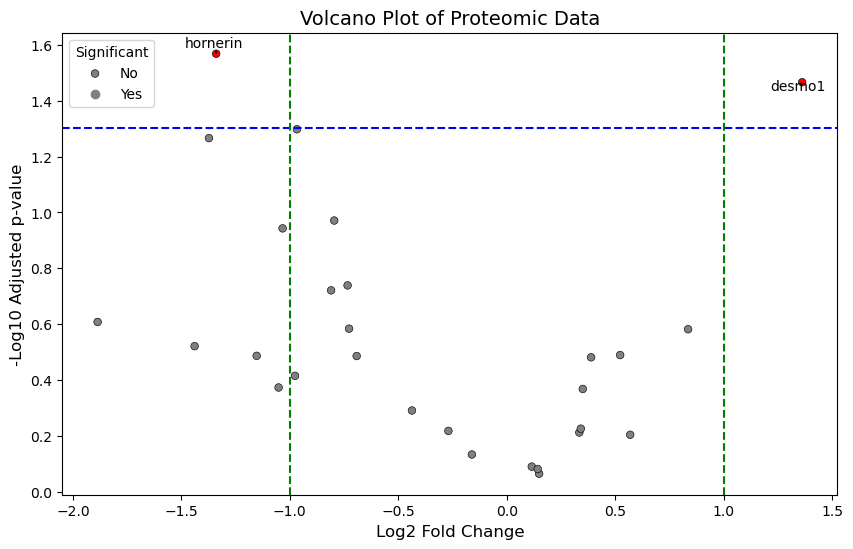

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
from adjustText import adjust_text

# Set significance thresholds
p_value_threshold = 0.05
log2_fold_change_threshold = 1  # This corresponds to a fold change of 2

# Create significance boolean column
results_df['significant'] = (results_df['p_value'] < p_value_threshold) & (abs(results_df['log2_fold_change']) > log2_fold_change_threshold)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='log2_fold_change', 
    y='minus_log10_p_value', 
    data=results_df, 
    hue='significant',  # Color by the 'significant' column
    palette={True: 'red', False: 'grey'},  # Red for significant, grey for non-significant
    s=30,  # Adjust the size of the markers
    edgecolor='black'  # Add a black boundary around each marker
)

# Add title and labels with increased font size
plt.title('Volcano Plot of Proteomic Data', fontsize=14)
plt.xlabel('Log2 Fold Change', fontsize=12)
plt.ylabel('-Log10 Adjusted p-value', fontsize=12)

# Add significance lines
plt.axhline(y=-np.log10(p_value_threshold), color='blue', linestyle='--')
plt.axvline(x=log2_fold_change_threshold, color='green', linestyle='--')
plt.axvline(x=-log2_fold_change_threshold, color='green', linestyle='--')

# Annotate significant points
significant_points = results_df[results_df['significant']]
texts = [plt.text(row['log2_fold_change'], row['minus_log10_p_value'], row['Protiens']) 
         for _, row in significant_points.iterrows()]

# Adjust text to avoid overlap
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='black'))

plt.legend(title='Significant', loc='upper left', labels=['No', 'Yes'])

# Save the plot to a file
plt.savefig("Volcano_plot.svg", format='svg')
plt.show()

In [19]:
names_df = pd.read_excel ('/Users/shahansd/SM_ Proteomics data/KM From 50 most abundant proteins A ja B.xlsx', sheet_name = 'Nimet')

# Now, let's create a dictionary from the Excel data for easy lookup of proper names
protein_name_dict = pd.Series(names_df['Proper'].values, index=names_df['Protien']).to_dict()

# Now, map the proper names to the 'Protiens' column in the samples_df
samples_df['ProperNames'] = samples_df['Protiens'].map(protein_name_dict)

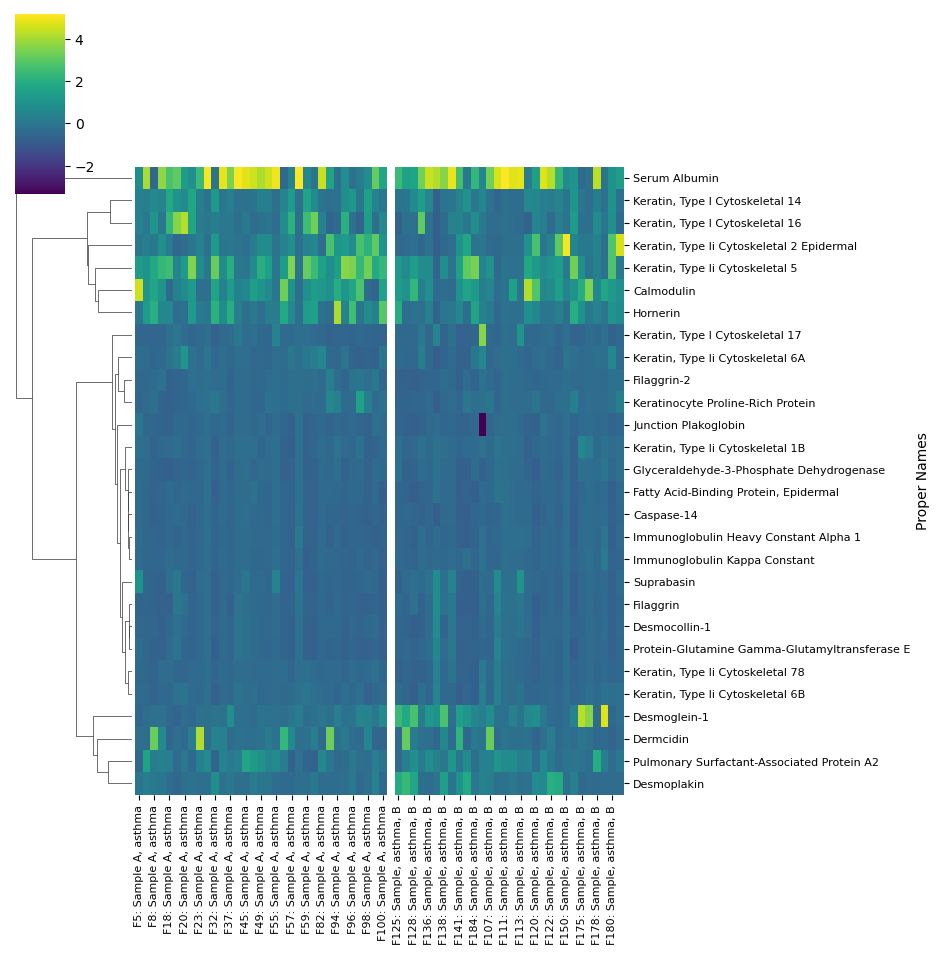

In [20]:
from scipy.cluster.hierarchy import linkage
from scipy.stats import zscore

# Assuming 'samples_df' has the first two and last column as non-numeric and should be excluded
# Exclude first two and last columns
numeric_data = samples_df.iloc[:, 2:-1]

# Standardize the data (mean-center and scale)
standardized_data = numeric_data.apply(zscore)

# Drop any NaN values to avoid issues during clustering
standardized_data_clean = standardized_data.dropna()

# Compute the linkage matrix using the Ward variance minimization algorithm
row_linkage = linkage(standardized_data_clean, method='ward')

# Proper names for y-axis labels from 'ProperNames' column
y_labels = samples_df['ProperNames']

# Insert a column of NaN values at the correct position to create a visual separation
n_a = len(asthma_a_columns)  # Assuming asthma_a_columns is still relevant after dropping columns
separation = pd.DataFrame(np.nan, index=standardized_data_clean.index, columns=['Separation'])
standardized_data_with_sep = pd.concat([standardized_data_clean.iloc[:, :n_a], separation, standardized_data_clean.iloc[:, n_a:]], axis=1)

# Create a clustermap without row colors but with a color bar as legend
g = sns.clustermap(standardized_data_with_sep, row_linkage=row_linkage, col_cluster=False, cmap='viridis',
                   cbar_pos=(0.02, 0.8, 0.05, 0.18),  # Example position for color bar
                   yticklabels=y_labels)

# Draw a black line where the NaN values are to emphasize the separation
plt.axvline(x=n_a, color='black', linewidth=2)

# Improve the appearance for publication
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), fontsize=8)  # Adjust to fit your data
plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), fontsize=8, rotation=90)  # Adjust to fit your data

# Set y-axis label
g.ax_heatmap.set_ylabel('Proper Names')

# Show the plot
plt.savefig("Heatmap_3.svg", format='svg')
plt.show()


